# Clip WorldCover to AOI
## Cut WorldCover tile to your Area of Interest

This notebook clips a large WorldCover tile to your specific AOI using a GeoJSON file.

## 1. Import Libraries

In [8]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Configuration

In [9]:
# Input paths
WORLDCOVER_DIR = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Artem"
GEOJSON_DIR = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/aois_json"
SENTINEL_DIR = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/sentinel_data"

# Output directory
OUTPUT_DIR = "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Map cities to their WorldCover files
CITIES = {
    "London": "London_WC.tif",
    "Melbourne": "Melbourne_WC.tif",
    "Paris": "Paris_WC.tif",
    "San_Francisco": "San_Francisco_WC.tif",
    "Seattle": "Seattle.tif"
}

print("Configuration:")
print(f"  WorldCover folder: {WORLDCOVER_DIR}")
print(f"  GeoJSON folder: {GEOJSON_DIR}")
print(f"  Sentinel folder: {SENTINEL_DIR}")
print(f"  Output folder: {OUTPUT_DIR}")
print(f"\nCities to process: {list(CITIES.keys())}")

Configuration:
  WorldCover folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Artem
  GeoJSON folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/aois_json
  Sentinel folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/sentinel_data
  Output folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped

Cities to process: ['London', 'Melbourne', 'Paris', 'San_Francisco', 'Seattle']


## 3. Load and Inspect Input Files

In [10]:
print("="*70)
print("CHECKING INPUT FILES AND TARGET CRS")
print("="*70)

# Check all files exist and get target CRS from OSM labels
target_crs = {}

for city, wc_file in CITIES.items():
    wc_path = os.path.join(WORLDCOVER_DIR, wc_file)
    geojson_path = os.path.join(GEOJSON_DIR, f"{city}.geojson")
    osm_path = os.path.join(SENTINEL_DIR, city, f"{city}_OSM_labels.tif")
    
    wc_exists = os.path.exists(wc_path)
    geojson_exists = os.path.exists(geojson_path)
    osm_exists = os.path.exists(osm_path)
    
    print(f"\n{city}:")
    print(f"  {'OK' if wc_exists else 'MISSING'} WorldCover: {wc_file}")
    print(f"  {'OK' if geojson_exists else 'MISSING'} GeoJSON: {city}.geojson")
    print(f"  {'OK' if osm_exists else 'MISSING'} OSM Labels: {city}_OSM_labels.tif")
    
    if osm_exists:
        with rasterio.open(osm_path) as src:
            target_crs[city] = src.crs
            print(f"  Target CRS: {src.crs}")

print("\n" + "="*70)
print("WorldCover will be reprojected to match each city's UTM zone")
print("="*70)

CHECKING INPUT FILES AND TARGET CRS

London:
  OK WorldCover: London_WC.tif
  OK GeoJSON: London.geojson
  OK OSM Labels: London_OSM_labels.tif
  Target CRS: EPSG:32630

Melbourne:
  OK WorldCover: Melbourne_WC.tif
  OK GeoJSON: Melbourne.geojson
  OK OSM Labels: Melbourne_OSM_labels.tif
  Target CRS: EPSG:32755

Paris:
  OK WorldCover: Paris_WC.tif
  OK GeoJSON: Paris.geojson
  OK OSM Labels: Paris_OSM_labels.tif
  Target CRS: EPSG:32631

San_Francisco:
  OK WorldCover: San_Francisco_WC.tif
  OK GeoJSON: San_Francisco.geojson
  OK OSM Labels: San_Francisco_OSM_labels.tif
  Target CRS: EPSG:32610

Seattle:
  OK WorldCover: Seattle.tif
  OK GeoJSON: Seattle.geojson
  OK OSM Labels: Seattle_OSM_labels.tif
  Target CRS: EPSG:32610

WorldCover will be reprojected to match each city's UTM zone


## 4. Clip WorldCover to AOI

In [11]:
print("="*70)
print("CLIPPING & REPROJECTING WORLDCOVER TO MATCH OSM LABELS")
print("="*70)

results = {}

for city, wc_file in CITIES.items():
    print(f"\nProcessing {city}...")
    
    wc_path = os.path.join(WORLDCOVER_DIR, wc_file)
    geojson_path = os.path.join(GEOJSON_DIR, f"{city}.geojson")
    osm_path = os.path.join(SENTINEL_DIR, city, f"{city}_OSM_labels.tif")
    output_path = os.path.join(OUTPUT_DIR, f"{city}_WorldCover_clipped.tif")
    
    # Get target CRS and bounds from OSM labels
    with rasterio.open(osm_path) as osm_src:
        dst_crs = osm_src.crs
        dst_bounds = osm_src.bounds
        dst_width = osm_src.width
        dst_height = osm_src.height
        dst_transform = osm_src.transform
    
    print(f"  Target CRS: {dst_crs}")
    print(f"  Target shape: {dst_height} x {dst_width}")
    
    # Open WorldCover and reproject to match OSM labels exactly
    with rasterio.open(wc_path) as src:
        # Create output array
        dst_data = np.zeros((dst_height, dst_width), dtype=src.dtypes[0])
        
        # Reproject WorldCover to match OSM labels grid exactly
        reproject(
            source=rasterio.band(src, 1),
            destination=dst_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest  # Use nearest for categorical data
        )
        
        # Save the reprojected and clipped WorldCover
        out_meta = {
            "driver": "GTiff",
            "height": dst_height,
            "width": dst_width,
            "count": 1,
            "dtype": dst_data.dtype,
            "crs": dst_crs,
            "transform": dst_transform,
            "compress": "lzw"
        }
        
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(dst_data, 1)
    
    file_size = os.path.getsize(output_path) / (1024**2)
    results[city] = {
        "output": output_path,
        "shape": (dst_height, dst_width),
        "size_mb": file_size,
        "crs": str(dst_crs)
    }
    
    print(f"  Saved: {output_path}")
    print(f"  File size: {file_size:.2f} MB")

print("\n" + "="*70)
print("ALL CITIES PROCESSED!")
print("="*70)

CLIPPING & REPROJECTING WORLDCOVER TO MATCH OSM LABELS

Processing London...
  Target CRS: EPSG:32630
  Target shape: 512 x 512
  Saved: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped.tif
  File size: 0.02 MB

Processing Melbourne...
  Target CRS: EPSG:32755
  Target shape: 512 x 512
  Saved: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/Melbourne_WorldCover_clipped.tif
  File size: 0.02 MB

Processing Paris...
  Target CRS: EPSG:32631
  Target shape: 512 x 512
  Saved: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/Paris_WorldCover_clipped.tif
  File size: 0.02 MB

Processing San_Francisco...
  Target CRS: EPSG:32610
  Target shape: 512 x 512
  Saved: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/San_Francisco_WorldCover_clipped.tif
  File size: 0.02 MB

Processing Seattle...
  Target CRS: EPSG:32610
  Target shape: 512 x 512
  Saved: 

## 5. Analyze Clipped WorldCover

In [12]:
print("="*70)
print("WORLDCOVER ANALYSIS - ALL CITIES")
print("="*70)

# WorldCover class names
class_names = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/sparse vegetation",
    70: "Snow and ice",
    80: "Permanent water bodies",
    90: "Herbaceous wetland",
    95: "Mangroves",
    100: "Moss and lichen"
}

green_classes = [10, 20, 30]  # As per your Artem.ipynb configuration

for city in CITIES.keys():
    output_path = os.path.join(OUTPUT_DIR, f"{city}_WorldCover_clipped.tif")
    
    with rasterio.open(output_path) as src:
        data = src.read(1)
        crs = src.crs
    
    total_pixels = data.size
    unique_classes, counts = np.unique(data, return_counts=True)
    
    green_pixels = sum(count for cls, count in zip(unique_classes, counts) if cls in green_classes)
    green_pct = 100 * green_pixels / total_pixels
    
    print(f"\n{city} (CRS: {crs}):")
    print(f"  Shape: {data.shape}")
    print(f"  Total pixels: {total_pixels:,}")
    print(f"  Green pixels (10,20,30): {green_pixels:,} ({green_pct:.2f}%)")
    print(f"  Classes present: {list(unique_classes)}")

print("\n" + "="*70)

WORLDCOVER ANALYSIS - ALL CITIES

London (CRS: EPSG:32630):
  Shape: (512, 512)
  Total pixels: 262,144
  Green pixels (10,20,30): 55,022 (20.99%)
  Classes present: [np.uint8(10), np.uint8(30), np.uint8(40), np.uint8(50), np.uint8(60), np.uint8(80)]

Melbourne (CRS: EPSG:32755):
  Shape: (512, 512)
  Total pixels: 262,144
  Green pixels (10,20,30): 57,776 (22.04%)
  Classes present: [np.uint8(10), np.uint8(30), np.uint8(40), np.uint8(50), np.uint8(60), np.uint8(80), np.uint8(90)]

Paris (CRS: EPSG:32631):
  Shape: (512, 512)
  Total pixels: 262,144
  Green pixels (10,20,30): 23,383 (8.92%)
  Classes present: [np.uint8(10), np.uint8(30), np.uint8(40), np.uint8(50), np.uint8(60), np.uint8(80)]

San_Francisco (CRS: EPSG:32610):
  Shape: (512, 512)
  Total pixels: 262,144
  Green pixels (10,20,30): 23,443 (8.94%)
  Classes present: [np.uint8(10), np.uint8(30), np.uint8(40), np.uint8(50), np.uint8(60), np.uint8(80), np.uint8(90)]

Seattle (CRS: EPSG:32610):
  Shape: (512, 512)
  Total pixe

## 6. Visualize Clipped WorldCover

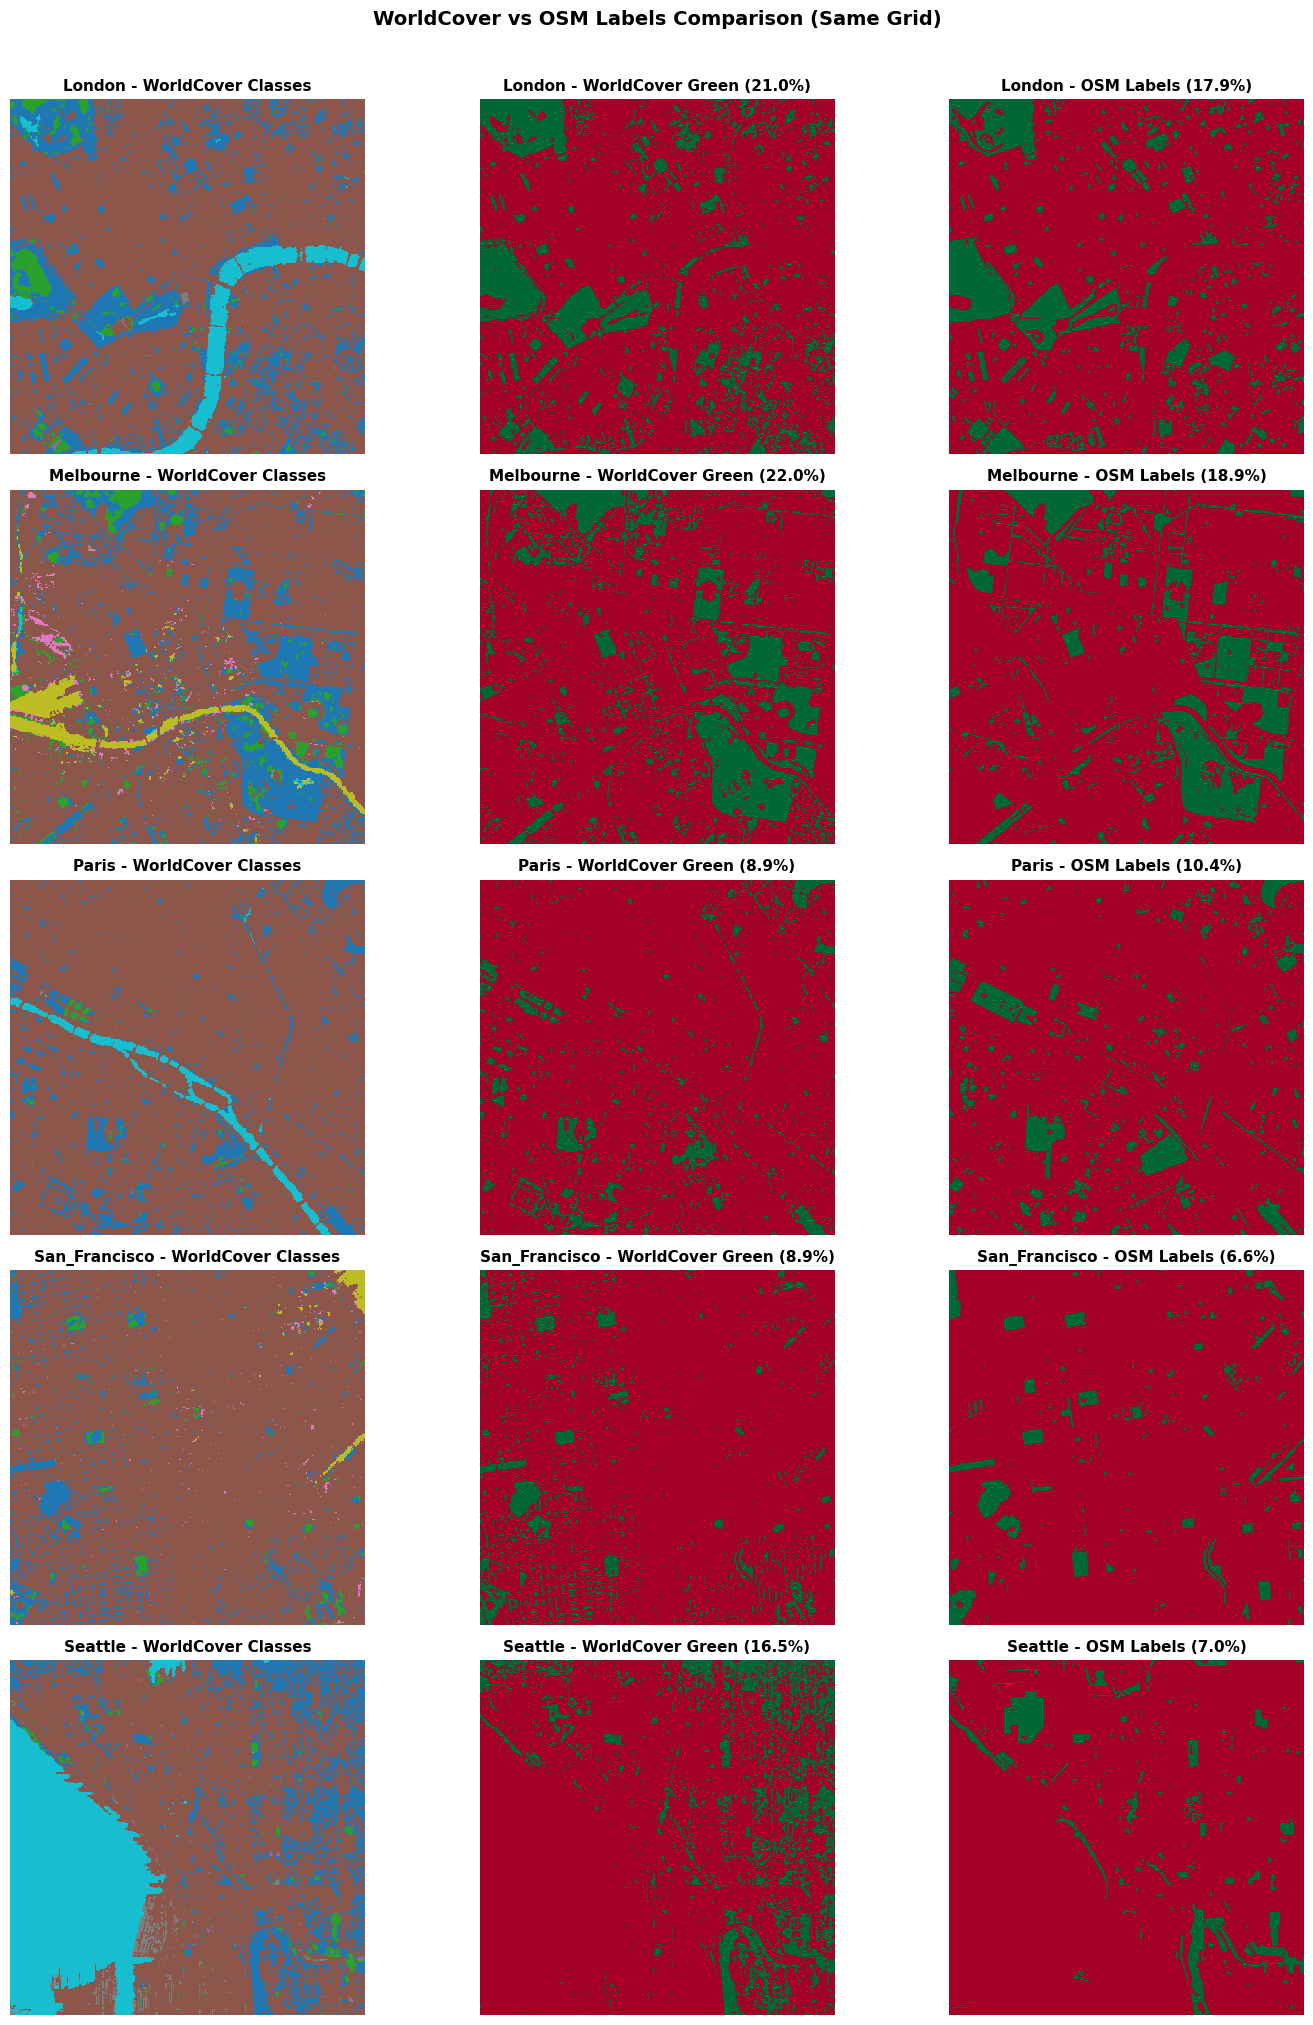


Visualization saved to /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/worldcover_osm_comparison.png


In [13]:
# Create visualization comparing WorldCover with OSM labels
fig, axes = plt.subplots(len(CITIES), 3, figsize=(15, 4*len(CITIES)))

for i, city in enumerate(CITIES.keys()):
    wc_path = os.path.join(OUTPUT_DIR, f"{city}_WorldCover_clipped.tif")
    osm_path = os.path.join(SENTINEL_DIR, city, f"{city}_OSM_labels.tif")
    
    with rasterio.open(wc_path) as src:
        wc_data = src.read(1)
    
    with rasterio.open(osm_path) as src:
        osm_data = src.read(1)
    
    # WorldCover binary (green classes)
    wc_green = np.isin(wc_data, green_classes).astype(np.uint8)
    
    # WorldCover classification
    axes[i, 0].imshow(wc_data, cmap='tab10', interpolation='nearest')
    axes[i, 0].set_title(f'{city} - WorldCover Classes', fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')
    
    # WorldCover binary green
    axes[i, 1].imshow(wc_green, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    green_pct = 100 * wc_green.sum() / wc_green.size
    axes[i, 1].set_title(f'{city} - WorldCover Green ({green_pct:.1f}%)', fontsize=11, fontweight='bold')
    axes[i, 1].axis('off')
    
    # OSM labels
    axes[i, 2].imshow(osm_data, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    osm_pct = 100 * osm_data.sum() / osm_data.size
    axes[i, 2].set_title(f'{city} - OSM Labels ({osm_pct:.1f}%)', fontsize=11, fontweight='bold')
    axes[i, 2].axis('off')

plt.suptitle('WorldCover vs OSM Labels Comparison (Same Grid)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "worldcover_osm_comparison.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {OUTPUT_DIR}/worldcover_osm_comparison.png")

## 7. Summary

In [14]:
print("="*70)
print("SUMMARY")
print("="*70)

print(f"\nOutput folder: {OUTPUT_DIR}")
print(f"\nClipped files created:")
for city in CITIES.keys():
    output_path = os.path.join(OUTPUT_DIR, f"{city}_WorldCover_clipped.tif")
    size_mb = os.path.getsize(output_path) / (1024**2)
    print(f"  {city}_WorldCover_clipped.tif ({size_mb:.2f} MB)")

print(f"\nGreen classes used: {green_classes} (Tree, Shrubland, Grassland)")

print(f"\nTo use in Artem.ipynb, update worldcover_paths:")
print("worldcover_paths = {")
for city in CITIES.keys():
    print(f'    "{city}": "{OUTPUT_DIR}/{city}_WorldCover_clipped.tif",')
print("}")

print("\n" + "="*70)

SUMMARY

Output folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped

Clipped files created:
  London_WorldCover_clipped.tif (0.02 MB)
  Melbourne_WorldCover_clipped.tif (0.02 MB)
  Paris_WorldCover_clipped.tif (0.02 MB)
  San_Francisco_WorldCover_clipped.tif (0.02 MB)
  Seattle_WorldCover_clipped.tif (0.02 MB)

Green classes used: [10, 20, 30] (Tree, Shrubland, Grassland)

To use in Artem.ipynb, update worldcover_paths:
worldcover_paths = {
    "London": "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/London_WorldCover_clipped.tif",
    "Melbourne": "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/Melbourne_WorldCover_clipped.tif",
    "Paris": "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/Paris_WorldCover_clipped.tif",
    "San_Francisco": "/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/WorldCover_Clipped/San_Francisco_WorldCover_clipped.tif",
   